## Track reconstruction figures

In [1]:
# %matplotlib notebook
%load_ext autoreload
%autoreload 1
import pyphysics as phys
from pyphysics.actroot_interface import TPCInterface, LineInterface
import hist
import uproot
import ROOT as r
import numpy as np
import copy

import matplotlib.pyplot as plt
import matplotlib.axes as mplaxes
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mpltick
import matplotlib.patches as mplpatch
import matplotlib.lines as mplline
import matplotlib.colors as mplcolor
import matplotlib as mpl

import sys

sys.path.append("../")
import styling as sty

### 3D event with projections

In [2]:
tpcdata = r.TFile("../Code/Events/run_155_entry_1296.root").Get("TPCData") #type: ignore
ev = TPCInterface(tpcdata)

### Contest to select event appearing in thesis

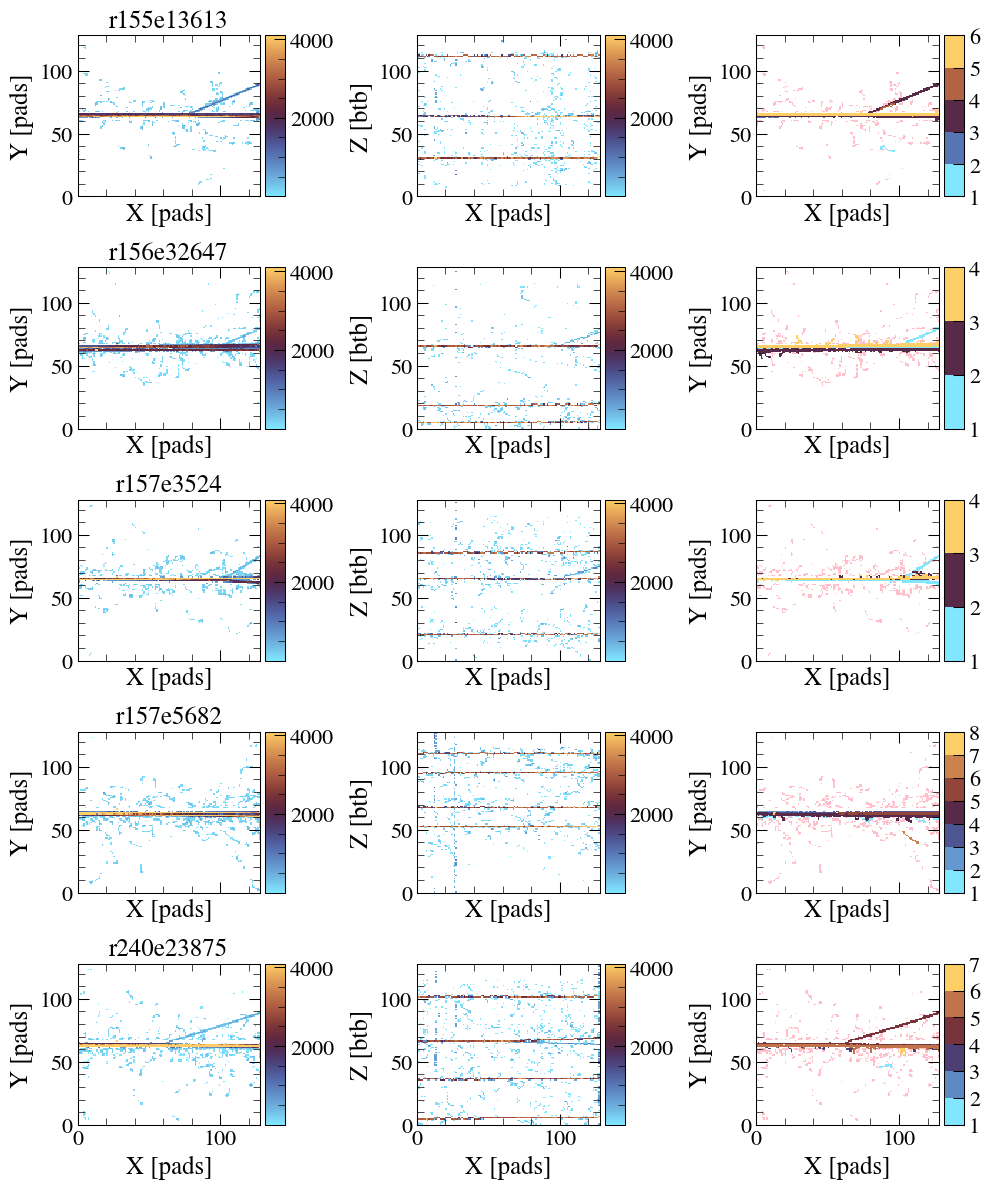

In [3]:
runentry = [(155, 13613), (156, 32647), (157, 3524), (157, 5682), (240, 23875)]
evs = []
for run, entry in runentry:
    file = r.TFile(f"../Code/Events/run_{run}_entry_{entry}.root") #type: ignore
    evs.append(TPCInterface(file.Get("TPCData")))

fig, axs = plt.subplots(len(evs), 3, figsize=(10, 12), sharex=True)

for i, ev in enumerate(evs):
    ax: mplaxes.Axes = axs[i, 0]
    ev.plot("xy", ax=ax)
    ax.set_title(f"r{runentry[i][0]}e{runentry[i][1]}")
    ax: mplaxes.Axes = axs[i, 1]
    ev.plot("xz", ax=ax)
    ax = axs[i, 2]
    ev.plot("xy", isCluster=True, withNoise=True, ax=ax)

fig.tight_layout()

We will choose **run 240 entry 23875**

In [4]:
def get_TPCData(file: str)->object:
    f = r.TFile(file) #type: ignore
    return f.Get("TPCData")

ev = evs[-1]

But add delta electron from run 157 entry 5682

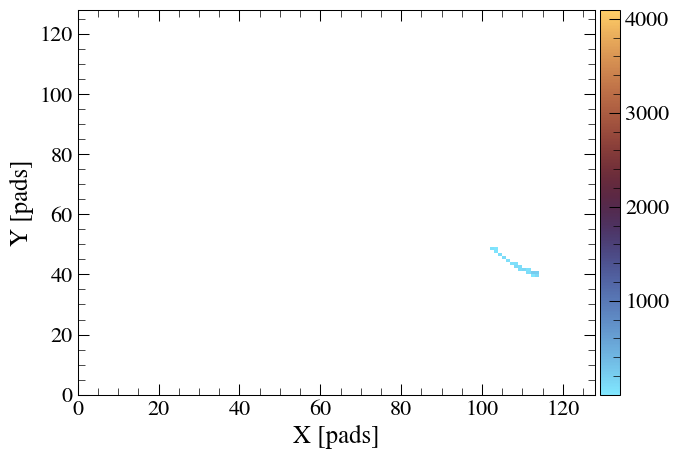

In [5]:
evdelta = TPCInterface(get_TPCData("../Code/Events/run_157_entry_5682.root"))
# Leave only the delta electron cluster
evdelta.fVoxels = {k: v for k, v in evdelta.fVoxels.items() if k == 5}
# And reset the histogram, filling only the contents of this voxel
evdelta.fHist.reset()
for v in evdelta.fVoxels[5]:
    pos = v.GetPosition()  # type: ignore
    evdelta.fHist.fill(pos.X(), pos.Y(), pos.Z(), weight=v.GetCharge())  # type: ignore


# And modify the other
def add_deltae(tpc: TPCInterface) -> None:
    tpc.fHist += evdelta.fHist
    idx = max(k for k in tpc.fVoxels.keys())
    tpc.fVoxels[idx + 1] = evdelta.fVoxels[5]
    tpc.fLines[idx + 1] = evdelta.fLines[5]

add_deltae(ev)

fig, ax = plt.subplots()
evdelta.plot(ax=ax, isCluster=False)

### Continuity example

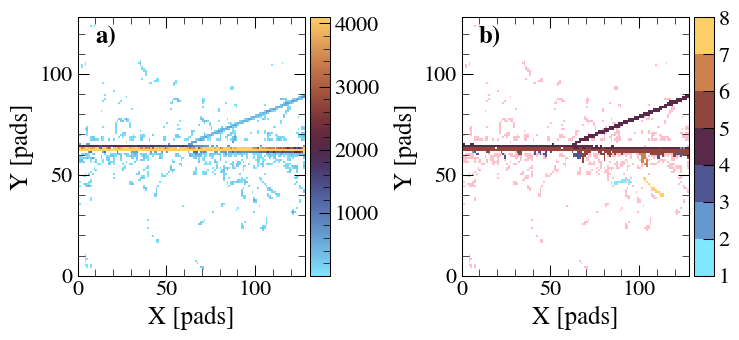

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3.5))
# Raw content
ax: mplaxes.Axes = axs[0]
ev.plot(ax=ax, cbar=True)

# Cluster
ax = axs[1]
plt.sca(ax)
ev.plot(ax=ax, proj="xy", isCluster=True, withNoise=True)

phys.utils.annotate_subplots(axs)
fig.tight_layout()
fig.savefig(sty.thesis + "continuity.pdf", dpi=300)

### Filtering

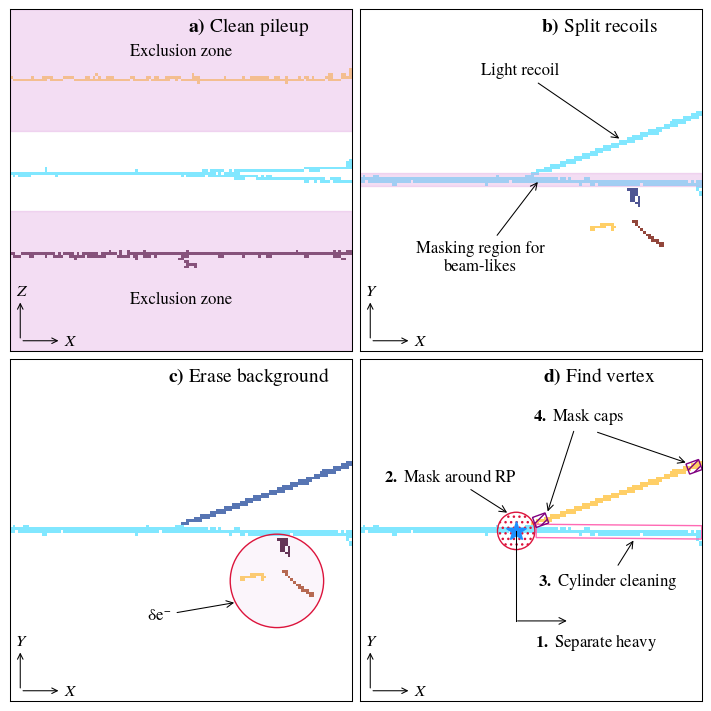

In [14]:
# %matplotlib tk

fig, axs = plt.subplots(2, 2, figsize=(7, 7), layout="constrained")


def sort_by_size(e: TPCInterface, custom: list = []) -> None:
    if len(custom):
        sort = custom
    else:
        sort = sorted(
            (k for k in e.fVoxels.keys() if k != -1),
            key=lambda k: len(e.fVoxels[k]),
            reverse=True,
        )
    v, l = {}, {}
    for idx, key in enumerate(sort):
        v[idx] = e.fVoxels[key]
        l[idx] = e.fLines[key]
    e.fVoxels = v
    e.fLines = l


# Clean pileup

sort_by_size(ev)

# Delete pileup blocking axis label
ev.fVoxels = {k: v for k,v in ev.fVoxels.items() if k != 3}

ax: mplaxes.Axes = axs[0, 0]
ev.plot(proj="xz", ax=ax, isCluster=True, cbar=False)
# Draw exclusion areas
pilelow = 210.0 / 4
pileup = 330.0 / 4
pilesty = {"color": "plum", "alpha": 0.35}
ax.axhspan(0, pilelow, **pilesty)
ax.axhspan(pileup, 128, **pilesty)
annsty = {"ha": "center", "va": "center", "fontsize": 12}
ax.annotate("Exclusion zone", xy=(64, (128 + pileup) / 2 + 7), **annsty)
ax.annotate("Exclusion zone", xy=(64, (0 + pilelow) / 2 - 7), **annsty)
# Get event after pileup
evplp = TPCInterface(
    get_TPCData("../Code/Events/run_240_entry_23875_after_pileup.root")
)
add_deltae(evplp)
sort_by_size(evplp)

# Break chi2
ax = axs[0, 1]
evplp.plot(proj="xy", isCluster=True, ax=ax)
refline = evplp.fLines[0].fPoint[:2]
refline[1] -= 1
ax.axhspan(refline[1] - 2.5, refline[1] + 2.5, **pilesty)
arrowsty = {"arrowstyle": "->", "linewidth": 0.75}
ax.annotate(
    "Masking region for\nbeam-likes",
    xy=(refline[0], refline[1]),
    xytext=(45, 35),
    **annsty,
    arrowprops=arrowsty,
)
ax.annotate(
    "Light recoil", xy=(98, 79), xytext=(60, 105), **annsty, arrowprops=arrowsty
)

# Get event after break
evbreak = TPCInterface(
    get_TPCData("../Code/Events/run_240_entry_23875_after_break.root")
)
add_deltae(evbreak)
sort_by_size(evbreak)

# Clean delta
ax = axs[1, 0]
evbreak.plot(proj="xy", ax=ax, isCluster=True)
circle = mplpatch.Circle(
    (100, 45),
    17.5,
    edgecolor="crimson",
    facecolor=mplcolor.to_rgba("plum", 0.1),
)
ax.add_patch(circle)
ax.annotate(
    r"$\delta$e$^{-}$", xy=(85, 37), xytext=(56, 32), **annsty, arrowprops=arrowsty
)

# Get event after this (I know the deltae is fake but just in case this is the result after all actions but FindRP)
evclean = TPCInterface(
    (get_TPCData("../Code/Events/run_240_entry_23875_ready_for_rp.root"))
)
sort_by_size(evclean)

# Find RP
ax = axs[1, 1]
evclean.plot(proj="xy", ax=ax, isCluster=True)
# Plot preliminary RP
rp = evclean.fRP
ax.plot(rp[0], rp[1], marker="*", color="dodgerblue", mfc="dodgerblue", ms=15)
# And now all the steps....
# 1 Break heavy
ybreak = 30
ax.plot([rp[0], rp[0]], [rp[1], ybreak], lw=0.75, color="black")
ax.annotate(
    "",
    xy=(rp[0] + 20, ybreak),
    xytext=(rp[0] - 0.5, ybreak),
    **annsty,
    arrowprops=arrowsty,
)
ax.annotate(r"$\mathbf{1.}$ Separate heavy", xy=(rp[0] + 30, ybreak - 8), **annsty)

# 2 Mask region around rp
circle = mplpatch.Circle((rp[0], rp[1]), 7, ec="crimson", fc="none", hatch="...")
ax.add_patch(circle)
ax.annotate(
    r"$\mathbf{2.}$ Mask around RP",
    xy=(56, 70),
    xytext=(34, 84),
    **annsty,
    arrowprops=arrowsty,
)

# 3 Cilynder cleaning
rect = mplpatch.Rectangle(
    (66, rp[1] - 2.5), width=62, height=5, angle=-0.5, color="hotpink", fill=False, lw=1
)
ax.add_patch(rect)
ax.annotate(
    r"$\mathbf{3.}$ Cylinder cleaning",
    xy=(103, 61),
    xytext=(93, 45),
    **annsty,
    arrowprops=arrowsty,
)

# 4 Capping fit
cap0 = mplpatch.Rectangle(
    (66, 65),
    width=5,
    height=4,
    angle=20,
    color="purple",
    ec="purple",
    fc="none",
    hatch="////",
)
cap1 = mplpatch.Rectangle(
    (123.5, 85),
    width=5,
    height=4,
    angle=20,
    color="purple",
    ec="purple",
    fc="none",
    hatch="////",
)
ax.add_patch(cap0)
ax.add_patch(cap1)
ax.annotate(
    r"$\mathbf{4.}$ Mask caps",
    xy=(70, 70),
    xytext=(82, 107),
    **annsty,
    arrowprops=arrowsty,
)
ax.annotate("", xy=(123, 89), xytext=(88, 101), **annsty, arrowprops=arrowsty)


# Common axis settings
for ax in axs.flat:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
# Annotate axis labels
labelsty = {
    "ha": "center",
    "va": "center",
    "fontsize": 12,
    "fontstyle": "italic",
}
# Subplots titles
titles = ["Clean pileup", "Split recoils", "Erase background", "Find vertex"]
for i, ax in enumerate(axs.flat):
    ax.annotate("X", xy=(0.175, 0.03), xycoords="axes fraction", **labelsty)
    ax.annotate(
        "",
        xy=(0.15, 0.03),
        xycoords="axes fraction",
        xytext=(0.03, 0.03),
        arrowprops=dict(arrowstyle="->", linewidth=0.75),
    )
    ax.annotate(
        "Z" if i == 0 else "Y", xy=(0.03, 0.175), xycoords="axes fraction", **labelsty
    )
    ax.annotate(
        "",
        xy=(0.03, 0.15),
        xycoords="axes fraction",
        xytext=(0.03, 0.03),
        arrowprops=dict(arrowstyle="->", linewidth=0.75),
    )
    # Title on upper right corner
    aux = chr(97 + i) + ")"
    ax.annotate(
        # rf"$\mathbf{{{i + 1}}}$ {titles[i]}",
        rf"$\mathbf{{{aux}}}$ {titles[i]}",
        xy=(0.7, 0.95),
        xycoords="axes fraction",
        ha="center",
        va="center",
        fontsize=14,
    )
# fig.tight_layout()
# fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.savefig(sty.thesis + "filtering.pdf", dpi=600)

### Physics extraction

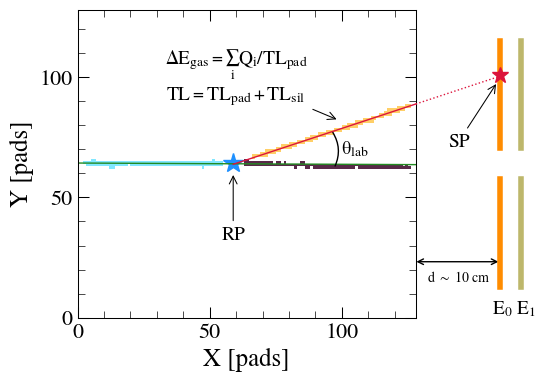

In [19]:
# %matplotlib tk

evfinal = TPCInterface(
    (get_TPCData("../Code/Events/run_240_entry_23875_after_all.root"))
)
sort_by_size(evfinal, [1, 2, 0])

fig = plt.figure(figsize=(6, 4))
gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[0.8, 0.2])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
# for ax in [ax1]:
#     ax.set_box_aspect(1)

evfinal.plot(isCluster=True, ax=ax1)
# Plot RP
rp = evfinal.fRP
rp[0] -= 0.5
rp[1] += 0.5
ax1.plot(rp[0], rp[1], marker="*", color="dodgerblue", mfc="dodgerblue", ms=15)
evfinal.fLines[0].plot(color="forestgreen")
# Annotate RP
ax1.annotate(
    "RP",
    xy=(rp[0], rp[1] - 4),
    xytext=(rp[0], rp[1] - 30),
    **annsty,
    arrowprops=arrowsty
)

# Silicons
ax2.set_ylim(0, 1)
ax2.set_xlim(0, 0.2)
ax2.grid(which="both")
# ax2.axhline(y=0.5, color="blue")
# ax2.get_yaxis().set_visible(False)


def mirror(plot, x, y):
    ynew = [1 - e for e in y]
    ax2.plot(
        [x for _ in range(len(y))],
        ynew,
        color=plot.get_color(),
        ls=plot.get_linestyle(),
        lw=plot.get_linewidth(),
    )


# f0
x0 = 0.10
y0 = [0.1, 0.45]
(f0,) = ax2.plot([x0, x0], y0, color="darkorange", lw=4)
mirror(f0, x0, y0)

# f1
x1 = 0.15
y1 = [0.1, 0.45]
(f1,) = ax2.plot([x1, x1], y1, color="darkkhaki", lw=4)
mirror(f1, x1, y1)

line = evfinal.fLines[2]


# Line in active region
def transform(line: LineInterface, xmin, xmax):
    xd = np.linspace(xmin, xmax, 2)
    yd = [line.moveToX(x)[1] for x in xd]
    ac = np.array(
        [
            (ax1.transData + ax1.transAxes.inverted()).transform([x, y])
            for x, y in zip(xd, yd)
        ]
    )
    # print("ac: ", ac)
    fc = np.array(
        [(ax1.transAxes + fig.transFigure.inverted()).transform([x, y]) for x, y in ac]
    )
    # print("fc: ", fc)
    return fc


# Line in active region
lactive = transform(line, rp[0], 128)
l0 = mplline.Line2D(lactive[:, 0], lactive[:, 1], color="crimson", lw=1)
l0.set_transform(fig.transFigure)
fig.add_artist(l0)
# Line in distance to silicons
ltosil = transform(line, 128, 160)
l1 = mplline.Line2D(ltosil[:, 0], ltosil[:, 1], color="crimson", lw=1, ls=":")
l1.set_transform(fig.transFigure)
fig.add_artist(l1)

# Increase size of annotations now
annsty["fontsize"] = 14
# Annotate charge average and TL
ax1.annotate(
    r"$\Delta E_{gas} = \sum_{i}{Q_{i}} / TL_{pad}$"
    + "\n"
    + r"$TL = TL_{pad} + TL_{sil}$",
    xy=(99, 82),
    xytext=(60, 100),
    **annsty,
    arrowprops=arrowsty,
)

# Distance to silicons
ax1.annotate("", xy=(0.685, 0.25), xytext=(0.831,0.25),
            xycoords=fig.transFigure, textcoords=fig.transFigure,
            arrowprops=dict(arrowstyle="<->"))
ax1.annotate(r"d $\sim$ 10 cm", xy=(0.76, 0.20), ha="center",
            xycoords=fig.transFigure, fontsize=10)
ax2.set_axis_off()

# Theta
ax1.annotate("", xy=(96, 78), xytext=(97, 62),
            arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=.3"))
ax1.annotate(r"$\theta_{lab}$", xy=(105, 70), **annsty)

# DeltaE sil
ax1.annotate(r"E$_0$ E$_1$", xy=(0.815, 0.12), xycoords=fig.transFigure, fontsize=14)

# Silicon point
ax2.plot(0.1, 0.789, color="crimson", mfc="crimson", marker="*", ms=12, zorder=4)
ax1.annotate(
    "SP",
    xy=(0.825, 0.7),
    xycoords=fig.transFigure,
    xytext=(0.76, 0.55),
    **annsty,
    arrowprops=arrowsty,
)

# Axis settings
ax1.set_yticks([0, 50, 100])

# DO NOT CALL THIS OTHERWISE THE POSITIONS WILL CHANGE
# plt.tight_layout()
# plt.show()
fig.savefig(sty.thesis + "track_physics.pdf")